# Predicting cryptocurrencies: Seq-to-Seq Regression
The problem can be approached from two different perspectives:
* Classification (e.g. buy, hold, sell)
* Regression (future price)

In this notebook we'll approach the problem from a **regression** perspective, trying to predict the price of a cryptocurrency in the next 10 minutes from the observation of 4 cryptocurrencies prices in the previous 60 minutes (**sequence-to-sequence**).

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Lorenzo-Giardi/tf-keras/blob/master/6_RNN/6_seqtoseq_reg_cryptos_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Imports and global parameters

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

import pandas as pd
import numpy as np
import tensorflow as tf
import random
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

from random import randint
from sklearn import preprocessing
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization, Flatten, Conv1D, TimeDistributed
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

In [2]:
from rnn_utils import generate_time_series, plot_series, plot_multiple_forecasts, last_time_step_mse, plot_learning_curves

In [3]:
SEQ_LEN = 60 # last minutes to use as feature
FUTURE_PERIOD_PREDICT = 10 # period over which to make the prediction
RATIO_TO_PREDICT = "ETH-USD"
EPOCHS = 10
BATCH_SIZE = 64
NAME = f'{RATIO_TO_PREDICT}-{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}'

## Import Data

In [4]:
col_names = ['time', 'low', 'high', 'open', 'close', 'volume']
df = pd.read_csv("crypto_data/LTC-USD.csv", names = col_names)

print(df.head())

         time        low       high       open      close      volume
0  1528968660  96.580002  96.589996  96.589996  96.580002    9.647200
1  1528968720  96.449997  96.669998  96.589996  96.660004  314.387024
2  1528968780  96.470001  96.570000  96.570000  96.570000   77.129799
3  1528968840  96.449997  96.570000  96.570000  96.500000    7.216067
4  1528968900  96.279999  96.540001  96.500000  96.389999  524.539978


In [5]:
main_df = pd.DataFrame()

ratios = ['BTC-USD', 'LTC-USD', 'ETH-USD', 'BCH-USD']
for ratio in ratios:
    # read CSV from path
    df_path = f'crypto_data/{ratio}.csv'
    df = pd.read_csv(df_path, names = col_names)
    
    # rename columns
    df.rename(columns = {'close': f'{ratio}_close', 'volume': f'{ratio}_volume'}, inplace = True)
    # set time as index
    df.set_index('time', inplace = True)
    # select only close price and volume columns
    df = df[[f'{ratio}_close', f'{ratio}_volume']]
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df)

print(main_df.head())

            BTC-USD_close  BTC-USD_volume  LTC-USD_close  LTC-USD_volume  \
time                                                                       
1528968660    6489.549805        0.587100      96.580002        9.647200   
1528968720    6487.379883        7.706374      96.660004      314.387024   
1528968780    6479.410156        3.088252      96.570000       77.129799   
1528968840    6479.410156        1.404100      96.500000        7.216067   
1528968900    6479.979980        0.753000      96.389999      524.539978   

            ETH-USD_close  ETH-USD_volume  BCH-USD_close  BCH-USD_volume  
time                                                                      
1528968660            NaN             NaN     871.719971        5.675361  
1528968720      486.01001       26.019083     870.859985       26.856577  
1528968780      486.00000        8.449400     870.099976        1.124300  
1528968840      485.75000       26.994646     870.789978        1.749862  
1528968900      4

## Train-test split, normalization, sequence creation and data balancing

Notice that since sequences are very close together and are highly correlated, it would be a bad idea to take a random sample to use as a validation/test set, as it would be extremely similar to instances in the training set. Instead, we have to take a whole period (possibly the most recent one) and use it for testing.

In this case we'll take the last 5-10% of the data.

In [6]:
# ensure that time is sorted
times = sorted(main_df.index.values)
threshold = times[-int(0.05*len(times))]
print(f'Time threshold for train-validation split: {threshold}')

Time threshold for train-validation split: 1534922100


In [7]:
# tain-validation split
validation_main_df = main_df[(main_df.index >= threshold)]
train_main_df = main_df[(main_df.index < threshold)]

Now define a preprocessing function that will be applied to both, the training and validation sets.
* Transform absolute prices into percentage changes
* Normalize data to be in (0,1)
* Drop NAs
* Create sequences that will be used as features (X)

In [8]:
# define a preprocessing function
def preprocess_df(df, print_df = False):
    
    pd.options.mode.chained_assignment = None
    # transform data to percentage variation and normalize
    for col in df.columns:
        #if col != 'target':
        df[col] = df[col].pct_change()
        df.dropna(inplace = True)
        df[col] = preprocessing.scale(df[col].values)
            
    df.dropna(inplace = True)
    if print_df: print(df.head())
    
    # create sequences of lenght SEQ_LEN to be used as features (X)
    # sequential_data is a list [sequences(X), targets(y)]
    sequential_data = []
    prev_days = deque(maxlen = SEQ_LEN + FUTURE_PERIOD_PREDICT)
    for i in df.values:
        prev_days.append([n for n in i])
        if len(prev_days) == (SEQ_LEN+FUTURE_PERIOD_PREDICT):
            sequential_data.append(np.array(prev_days))
            
    random.shuffle(sequential_data)
    sequential_data = np.array(sequential_data)
    if print_df: print('\nsequential_data shape: ', np.shape(sequential_data))
        
    # split into X and y
    X = sequential_data[:, :SEQ_LEN, :]
    y = sequential_data[:, -FUTURE_PERIOD_PREDICT:, 4][..., np.newaxis]

    if print_df: print('\nDimensions: [n of sequences, sequences lenght, features]')
    if print_df: print('X_data shape: ', np.shape(X))
    if print_df: print('y_data shape: ', np.shape(y))
    
    return np.array(X), np.array(y)

In [9]:
train_x, train_y = preprocess_df(train_main_df, print_df = True)
valid_x, valid_y = preprocess_df(validation_main_df)

            BTC-USD_close  BTC-USD_volume  LTC-USD_close  LTC-USD_volume  \
time                                                                       
1528969140      -0.002513       -0.078919      -0.540429       -0.117090   
1528969200      -0.229992        0.003410       0.004048       -0.118307   
1528969260      -0.000830       -0.074039       0.004048       -0.072997   
1528969320       0.116299       -0.049626       0.004048       -0.108241   
1528969380       0.000937       -0.082052       0.004048       -0.048516   

            ETH-USD_close  ETH-USD_volume  BCH-USD_close  BCH-USD_volume  
time                                                                      
1528969140       0.004601       -0.047838       0.011062       -0.006217  
1528969200       0.004601       -0.045377       0.257552       -0.005884  
1528969260       0.021273       -0.032900       0.265415       -0.006200  
1528969320       0.004601       -0.049530       0.455951       -0.005898  
1528969380       

## Linear Baseline

In [10]:
model_bsl = Sequential([
        Flatten(input_shape = (train_x.shape[1:])),
        Dense(10)])

model_bsl.compile(loss = 'mse', optimizer = 'nadam')

history_bsl = model_bsl.fit(train_x, train_y,
                   batch_size = BATCH_SIZE,
                   epochs = 5,
                   validation_data = (valid_x, valid_y))

Train on 82168 samples, validate on 3796 samples
Epoch 1/5
82168/82168 [==============================] - 3s 39us/sample - loss: 1.5063 - val_loss: 1.1707
Epoch 2/5
82168/82168 [==============================] - 3s 32us/sample - loss: 1.1458 - val_loss: 1.0625
Epoch 3/5
82168/82168 [==============================] - 3s 34us/sample - loss: 1.0594 - val_loss: 1.0383
Epoch 4/5
82168/82168 [==============================] - 3s 34us/sample - loss: 1.0388 - val_loss: 1.0364
Epoch 5/5
82168/82168 [==============================] - 3s 34us/sample - loss: 1.0365 - val_loss: 1.0384


In [11]:
y_pred = model_bsl.predict(valid_x)[..., np.newaxis]
print(f'Predictions shape: {y_pred.shape}')
print(f'valid_x shape: {valid_x.shape}')
print(f'valid_y shape: {valid_y.shape}')

Predictions shape: (3796, 10, 1)
valid_x shape: (3796, 60, 8)
valid_y shape: (3796, 10, 1)


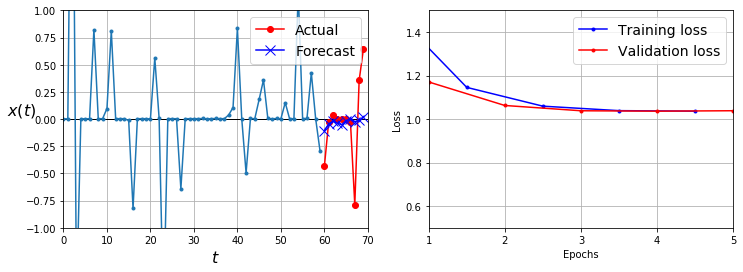

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
seq = randint(0, 1000)

plt.sca(axes[0])
plot_multiple_forecasts(valid_x, valid_y, y_pred, seq_id=seq)

plt.sca(axes[1])
plot_learning_curves(history_bsl.history["loss"], history_bsl.history["val_loss"], axis = [1, 5, 0.5, 1.5])

plt.show()

## Recurrent Network


In [13]:
model = Sequential([
    Conv1D(128, 4, strides = 2, padding='valid', activation='relu', input_shape = train_x.shape[1:]),
    BatchNormalization(),
    
    GRU(64, activation = 'tanh', return_sequences = True),
    Dropout(0.2),
    BatchNormalization(),
    
    GRU(64, activation = 'tanh', return_sequences = False),
    Dropout(0.2),
    BatchNormalization(),
    
    Dense(32, activation = 'tanh'),
    Dropout(0.2),
    
    Dense(10),
])

opt = tf.keras.optimizers.Adam(lr=0.001, decay = 1e-6)

model.compile(loss = 'mse',
             optimizer = 'nadam'
             )

model.summary()

tensorboard = TensorBoard(log_dir = f'logs/{NAME}')
filepath = "RNN_Final-{epoch:02d}-{val_loss:.3f}.hdf5"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint(f"models/{NAME}/{filepath}", monitor='val_loss', verbose=1, save_best_only=True, mode='auto') # saves only the best ones
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto', restore_best_weights=True)

# create folder for checkpoints (or it will throw an error if not found!)
try:
    os.makedirs(f"models/{NAME}")
except:
    print("Directory already exists")  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 128)           4224      
_________________________________________________________________
batch_normalization (BatchNo (None, 29, 128)           512       
_________________________________________________________________
gru (GRU)                    (None, 29, 64)            37248     
_________________________________________________________________
dropout (Dropout)            (None, 29, 64)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 64)            256       
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

In [14]:
history = model.fit(train_x, train_y,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data = (valid_x, valid_y),
                   callbacks = [tensorboard, checkpoint, earlystop])

Train on 82168 samples, validate on 3796 samples
Epoch 1/10
82048/82168 [============================>.] - ETA: 0s - loss: 1.0653
Epoch 00001: val_loss improved from inf to 0.99163, saving model to models/ETH-USD-60-SEQ-10-PRED-1585144281/RNN_Final-01-0.992.hdf5
82168/82168 [==============================] - 67s 816us/sample - loss: 1.0649 - val_loss: 0.9916
Epoch 2/10
82112/82168 [============================>.] - ETA: 0s - loss: 1.0041
Epoch 00002: val_loss did not improve from 0.99163
82168/82168 [==============================] - 64s 780us/sample - loss: 1.0040 - val_loss: 0.9926
Epoch 3/10
82112/82168 [============================>.] - ETA: 0s - loss: 1.0006
Epoch 00003: val_loss did not improve from 0.99163
82168/82168 [==============================] - 63s 762us/sample - loss: 1.0005 - val_loss: 0.9916
Epoch 4/10
82112/82168 [============================>.] - ETA: 0s - loss: 0.9995
Epoch 00004: val_loss improved from 0.99163 to 0.99154, saving model to models/ETH-USD-60-SEQ-10-P

In [15]:
y_pred = model.predict(valid_x)[..., np.newaxis]
print(f'Predictions shape: {y_pred.shape}')
print(f'valid_x shape: {valid_x.shape}')
print(f'valid_y shape: {valid_y.shape}')

Predictions shape: (3796, 10, 1)
valid_x shape: (3796, 60, 8)
valid_y shape: (3796, 10, 1)


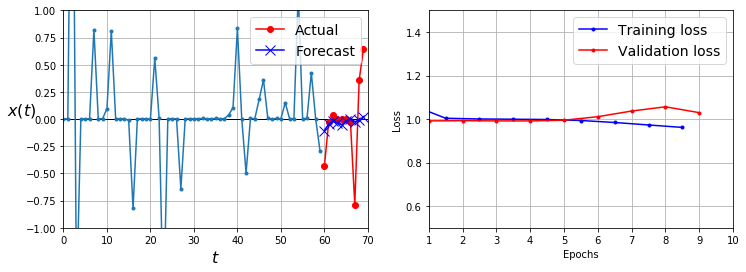

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

plt.sca(axes[0])
plot_multiple_forecasts(valid_x, valid_y, y_pred, seq_id=seq)

plt.sca(axes[1])
plot_learning_curves(history.history["loss"], history.history["val_loss"], axis = [1, 10, 0.5, 1.5])

plt.show()